In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

In [95]:
spacy.cli.download('en_core_web_md')
nlp = spacy.load('en_core_web_md')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [165]:
df = pd.read_csv(r'../datasets/reddit_dataframe.csv')

In [97]:
df[['subreddit','selftext']].isna().sum()

subreddit    0
selftext     1
dtype: int64

Despite there being no nulls in the target or main feature when I exported the dataframe, a null was somehow introduced. Normal methods like `df[df[['selftext', 'subreddit']] = df[df[['selftext', 'subreddit']].isnull()` are not working, and inplace doesn't work for multiple columns. I could apply inplace seperately to both columns, but I'll remove using the index because it seems like the most definitive way. There is clearly something unexpected going on

In [166]:
null_index = list(df[df[['selftext', 'subreddit']].isnull().any(axis = 1)].index)
df.drop(index = null_index, inplace = True)
df.index = range(len(df))

In [99]:
df[['subreddit','selftext']].isna().sum()

subreddit    0
selftext     0
dtype: int64

In [100]:
df.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,url_overridden_by_dest,crosspost_parent_list,crosspost_parent,post_hint,preview,author_cakeday,is_gallery,media_metadata,gallery_data,link_flair_template_id
0,NaN,antiwork,I wanted to get some opinions regarding someth...,t2_z8a567j,False,NaN,0,False,9 hour “working interview”,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,antiwork,Basically title. I’ve gotten several good job ...,t2_lgtpxmxc,False,NaN,0,False,Taking a job that requires an arbitration agre...,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,antiwork,I really want to share my experience that comp...,t2_11pigi,False,NaN,0,False,My experience working while my mother was dyin...,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,antiwork,My company leadership said they wanted to buy ...,t2_48epy,False,NaN,0,False,Outsourced: Buy your lunch.,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,antiwork,Just got my first paycheck at my new job and I...,t2_s5kc5zz,False,NaN,0,False,Overtime,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Visualizing the subreddit value counts:

In [298]:
values = df['subreddit'].value_counts(normalize = True).round(2)
values

jobs        0.53
antiwork    0.47
Name: subreddit, dtype: float64

In [301]:
# creating a standard color palette
jobs_color = '#3366cc'
anti_color = '#cc3333'

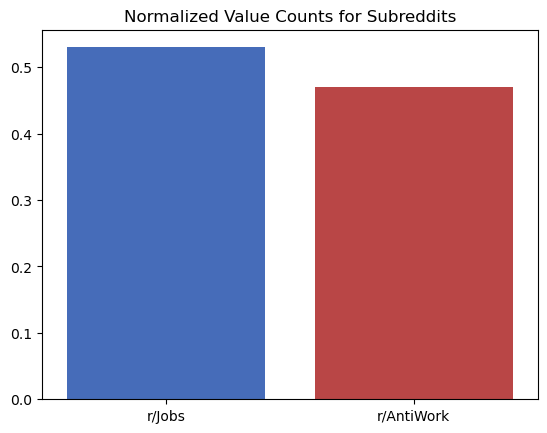

In [304]:
sns.barplot(x = values.index, y = values.values, palette = [jobs_color, anti_color]);
plt.title('Normalized Value Counts for Subreddits');
plt.xticks([0,1], ['r/Jobs', 'r/AntiWork']);
plt.savefig('sub_val_counts.png')

In [307]:
df['subreddit'].value_counts(normalize = True).round(2)

jobs        0.53
antiwork    0.47
Name: subreddit, dtype: float64

The classes are quite even. r/Jobs has a bit more representation, but the difference is within 10%. Both subs have over 3,200 posts.

In [101]:
def df_to_lem(old_df):
    
    anti_df = old_df[old_df['subreddit'] == 'antiwork'].copy()
    jobs_df = old_df[old_df['subreddit'] == 'jobs'].copy()

    def process_dataframe(old_df):
        corpus = []
        lem = []

        for post in old_df['selftext']:
            doc = nlp(str(post))
            corpus.append(doc)

        for ex in corpus:
            for token in ex:
                tk_dict = {
                    'text': token.text,
                    'POS': token.pos_,
                    'POS_exp': spacy.explain(token.pos_),
                    'dependency': token.dep_,
                    'dep_exp': spacy.explain(token.dep_),
                    'lemma': token.lemma_
                }
                lem.append(tk_dict)

        lem_df = pd.DataFrame(lem)
        return lem_df

    anti_lem_df = process_dataframe(anti_df)
    jobs_lem_df = process_dataframe(jobs_df)

    return anti_lem_df, jobs_lem_df

In [102]:
anti_lemma, jobs_lemma = df_to_lem(df)

C:\Users\User\anaconda3_1\envs\dsi\lib\site-packages\spacy\glossary.py:20: UserWarning: [W118] Term 'predet' not found in glossary. It may however be explained in documentation for the corpora used to train the language. Please check `nlp.meta["sources"]` for any relevant links.
  warnings.warn(Warnings.W118.format(term=term))
C:\Users\User\anaconda3_1\envs\dsi\lib\site-packages\spacy\glossary.py:20: UserWarning: [W118] Term 'predet' not found in glossary. It may however be explained in documentation for the corpora used to train the language. Please check `nlp.meta["sources"]` for any relevant links.
  warnings.warn(Warnings.W118.format(term=term))


## Most frequent nouns

Can we find any interesting trends by looking at which nouns occur the most frequently between the subreddits?

What are the most common nouns?

In [359]:
# top 10 nouns in r/AntiWork
anti_nouns = anti_lemma[anti_lemma['POS_exp'] ==  'noun']['lemma'].value_counts(normalize = True)
anti_nouns[:10]

job        0.034263
time       0.023518
day        0.022188
work       0.019946
company    0.017814
week       0.016415
year       0.016031
hour       0.014234
manager    0.014090
people     0.013988
Name: lemma, dtype: float64

In [358]:
# top 10 nouns in r/Jobs
jobs_nouns = jobs_lemma[jobs_lemma['POS_exp'] ==  'noun']['lemma'].value_counts(normalize = True)
jobs_nouns[:10]

job          0.063026
time         0.021870
company      0.020480
year         0.019448
interview    0.016498
work         0.015347
day          0.014137
week         0.013702
month        0.012355
position     0.011724
Name: lemma, dtype: float64

Posts on r/AntiWork are often fairly negative job-related horror stories. The top nouns here aren't that surprising, although "manager" is interesting - I assume there's a lot of posts from people who dislike their managers. Let's pull one up:

In [118]:
manager_mentions = [i for i in range(len(df['selftext'])) if 'manager' in df['selftext'][i]]
manager_mentions[:5]

[2, 7, 9, 16, 20]

In [119]:
df['selftext'].iloc[7]

'So I do door to door canvassing. It was near the end of our shift and I finished my neighborhood. I then sat down on the corner to take my 10 min break. During this, my manager pulls up in the van to pick me up, as it was around the time to get picked up and head to the office. I get in the van and he start berating me for sitting down. Says we aren’t allowed to do that, yadada, even tho it was my break. He then proceeds to rev the gas and go full speed over a residential speed bump, I sit in the far back which gets the most motion from bumps (he knows this because I got injured from him going over a train track bump too fast and scraped my elbow), on purpose so I then hit my head on the ceiling. I’m like wtf why’d you do that??? And he says because I’m sitting on company time. I got injured on my head and he did it on purpose. What are my options?? Can I sue? tl;dr boss intentionally sped over a speed bump so I could hit my head and get injured.'

In [120]:
df['subreddit'].iloc[7]

'antiwork'

As expected, this is quite a negative comment about a bad experience with a manager. I am curious to see what the overall sentiment for posts mentioning the word "manager" are, and if they differ between the subreddits, and if posts with this word are overall more negative than the average post across both subs.

In [121]:
df['selftext'][7]

'So I do door to door canvassing. It was near the end of our shift and I finished my neighborhood. I then sat down on the corner to take my 10 min break. During this, my manager pulls up in the van to pick me up, as it was around the time to get picked up and head to the office. I get in the van and he start berating me for sitting down. Says we aren’t allowed to do that, yadada, even tho it was my break. He then proceeds to rev the gas and go full speed over a residential speed bump, I sit in the far back which gets the most motion from bumps (he knows this because I got injured from him going over a train track bump too fast and scraped my elbow), on purpose so I then hit my head on the ceiling. I’m like wtf why’d you do that??? And he says because I’m sitting on company time. I got injured on my head and he did it on purpose. What are my options?? Can I sue? tl;dr boss intentionally sped over a speed bump so I could hit my head and get injured.'

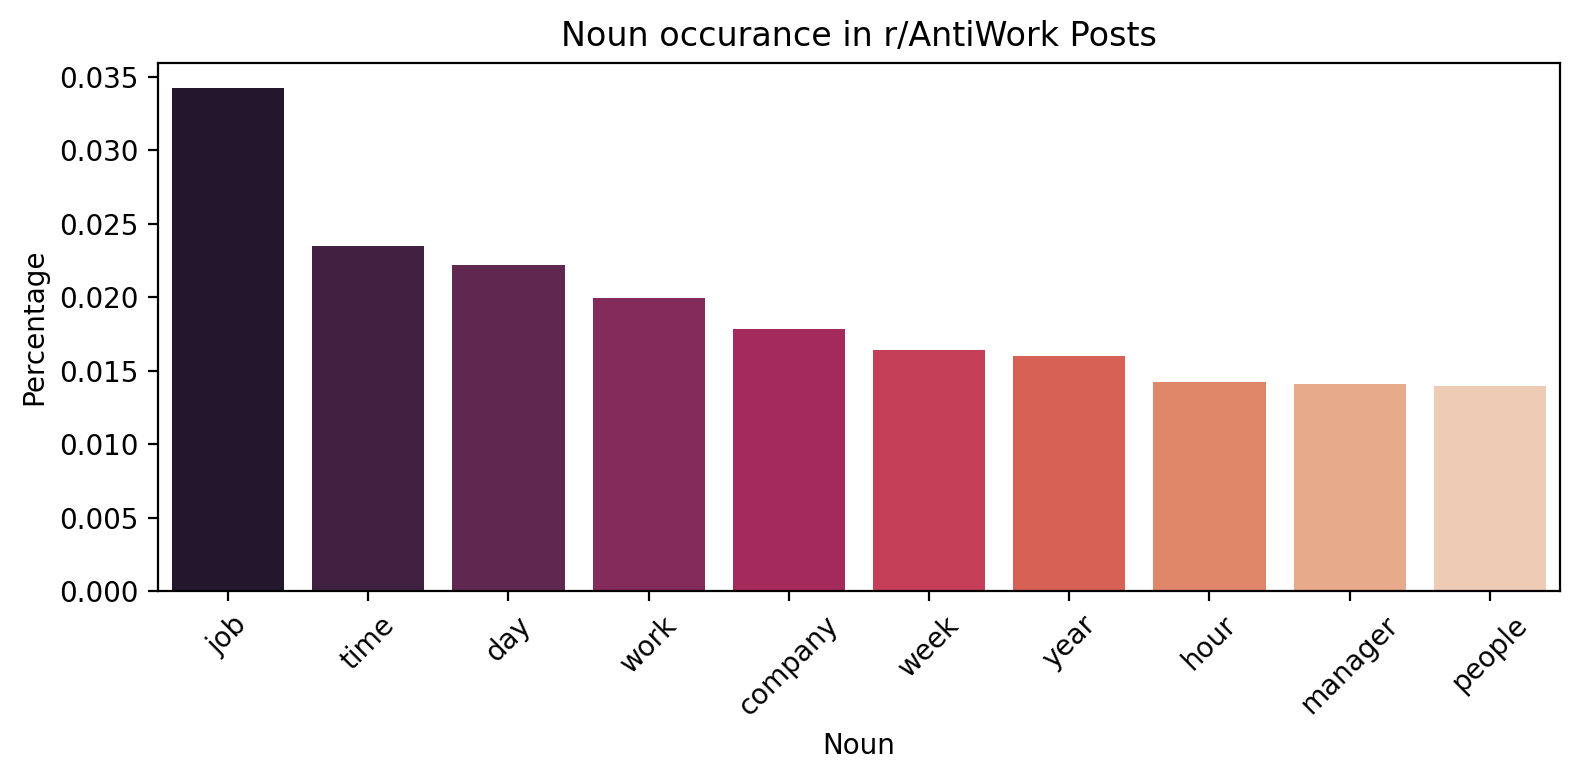

In [364]:
plt.figure(dpi=200, figsize = (8, 4))
sns.barplot(x = anti_nouns[:10].index, y = anti_nouns[:10], palette = 'rocket');
plt.xticks(rotation = 45);
plt.ylabel('Percentage');
plt.xlabel('Noun');
plt.title('Noun occurance in r/AntiWork Posts');
plt.tight_layout()
plt.savefig('AntiWork_nouns.png');

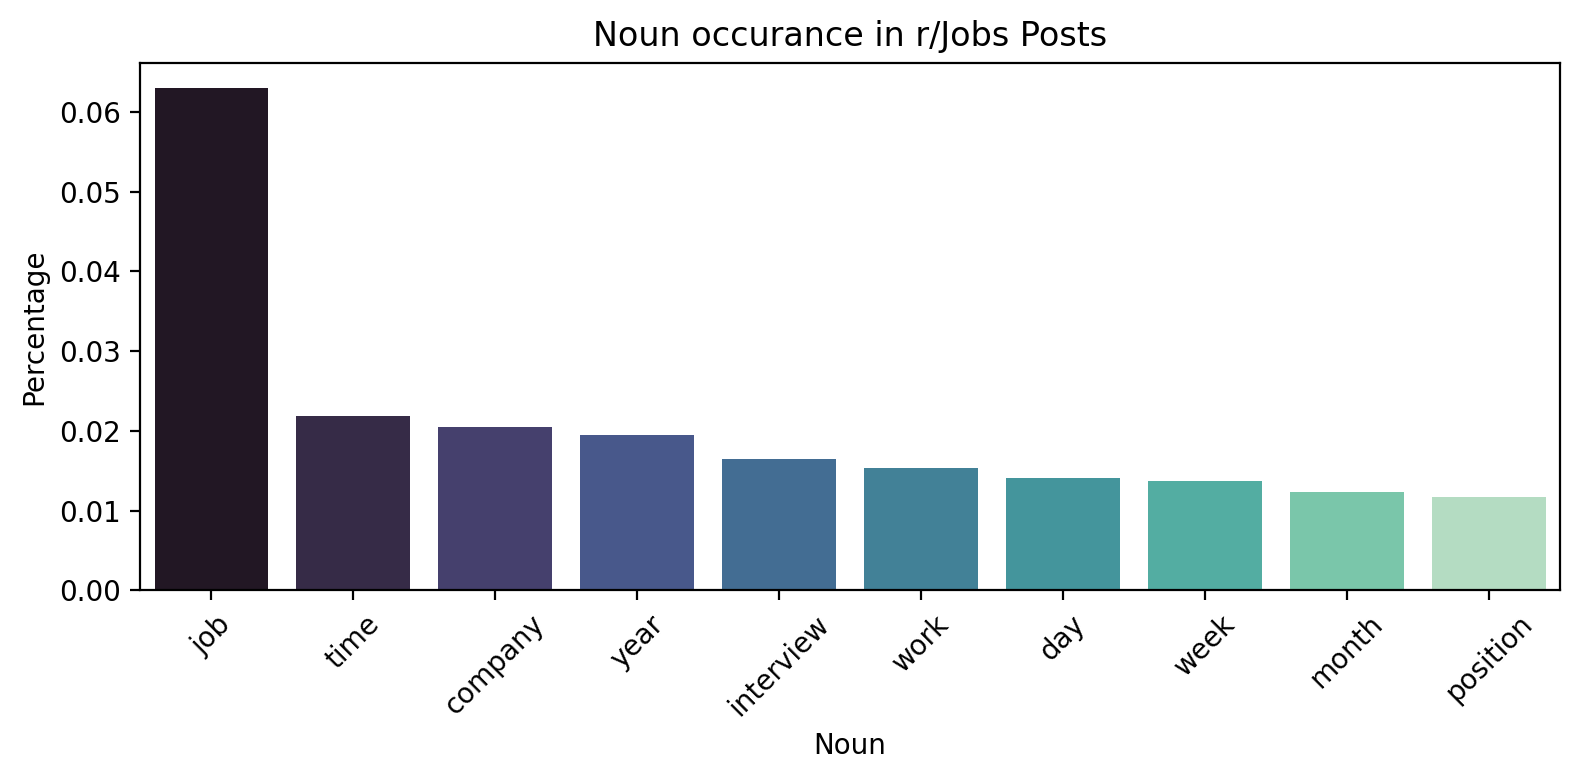

In [363]:
plt.figure(dpi=200, figsize = (8, 4))
sns.barplot(x = jobs_nouns[:10].index, y = jobs_nouns[:10], palette = 'mako');
plt.xticks(rotation = 45);
plt.ylabel('Percentage');
plt.xlabel('Noun');
plt.title('Noun occurance in r/Jobs Posts');
plt.tight_layout()
plt.savefig('Jobs_nouns.png')

While both subreddits frequently mention the word "job" in there posts, the nouns from r/Jobs seem to relate more to _getting_ a job, rather than complaints after actually having had the job. I'm assuming this based off "interview" and "position".

In [171]:
interview_mentions = [i for i in range(len(df['selftext'])) if 'interview' in df['selftext'][i]]
interview_mentions[-5:]

[6859, 6860, 6862, 6865, 6871]

In [174]:
df['selftext'].iloc[6860]

"After a strenuous, soul-sucking 6 month job search I finally got offered a brand new role! \n\nI had to have sent out hundreds of applications, did around 30-40 interviews, had 3 last-rounders that ultimately I didn't land as the best candidate. Dozens of screening calls for recruiters that ended up nowhere. But I finally did it, I got an offer! \n\nIf you're job searching, please don't give up and don't be afraid to get creative. I ended up landing this job through applying for another job, the hiring manager saw my experience and recommended me for this role that was not even listed online. \n\nApply to anything and everything that you believe you could be good at, you might find something you're great at!"

In [175]:
df['subreddit'].iloc[6860]

'jobs'

I'm only directly looking at one post from r/AntiWork which mentions the word "manager" and one post from r/Jobs which mentions the word "interview", so it's not very rigorous. That said, I would describe the tone of this post as "neutral", which is very different from the tone of the "manager" post from r/AntiWork.

## Seniment Analysis

These two cells are from Woojong Choi's work on the Hackathon project:

In [220]:
sent = SentimentIntensityAnalyzer()

In [221]:
df['sentiment'] = df['selftext'].apply(lambda x: sent.polarity_scores(x)['compound'])

In [129]:
sub_sentiment = df.groupby('subreddit').mean(numeric_only = True)['sentiment']
sub_sentiment

subreddit
antiwork   -0.024427
jobs        0.292369
Name: sentiment, dtype: float64

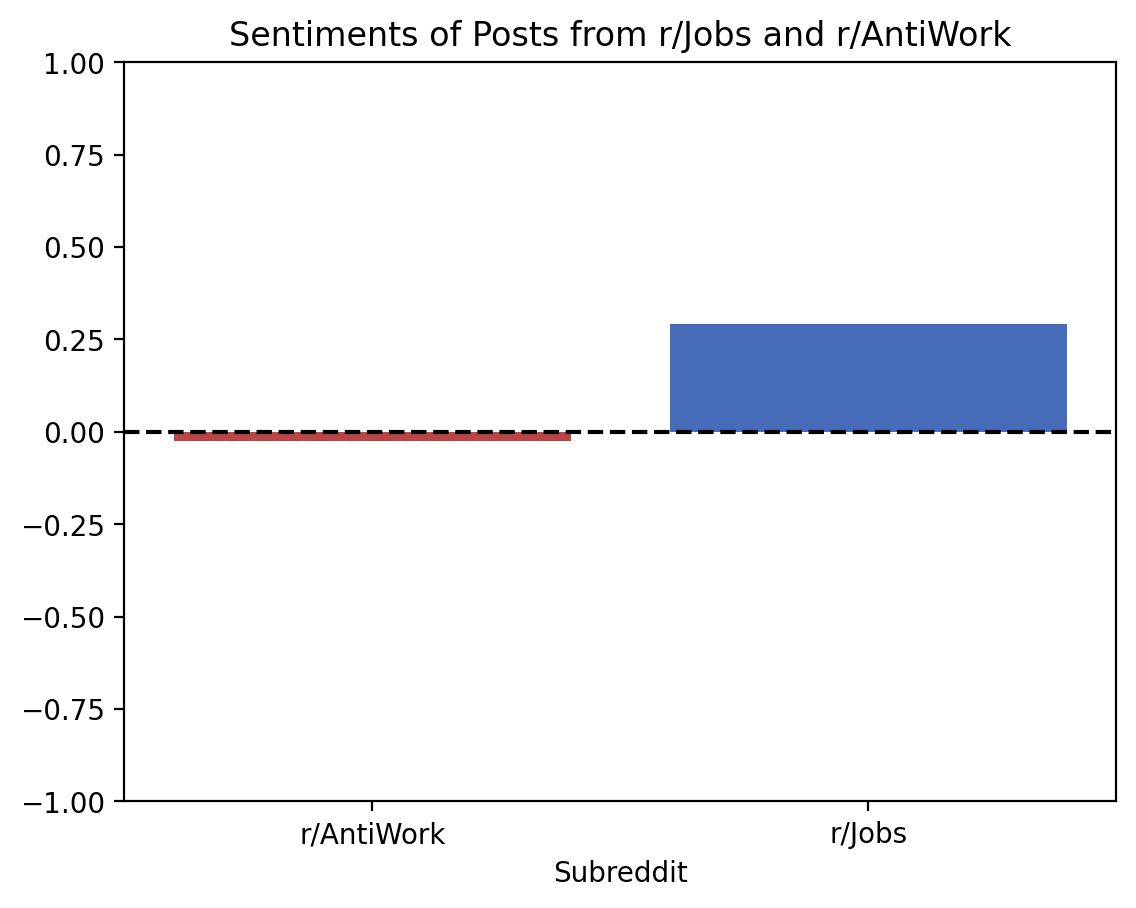

In [161]:
plt.figure(dpi = 200)
sns.barplot(x = sub_sentiment.index, y = sub_sentiment.values, palette = [anti_color, jobs_color]);
plt.axhline(y=0, color='black', linestyle='--', label='x=0');
plt.ylim(-1,1);
plt.title('Sentiments of Posts from r/Jobs and r/AntiWork');
plt.xticks([0,1], ['r/AntiWork', 'r/Jobs']);
plt.savefig('sentiment_barplot.png')
plt.xlabel('Subreddit');

Sentiment polarity is on a scale from -1 to 1, with -1 being extremely negative, and 1 extremely positive. So, on average, the tone of posts on r/Jobs is fairly positive, whereas the tone for posts on r/AntiWork tends to be neutral to slightly negative.

In [132]:
anti = df[df['subreddit'] == 'antiwork']
jobs = df[df['subreddit'] == 'jobs']

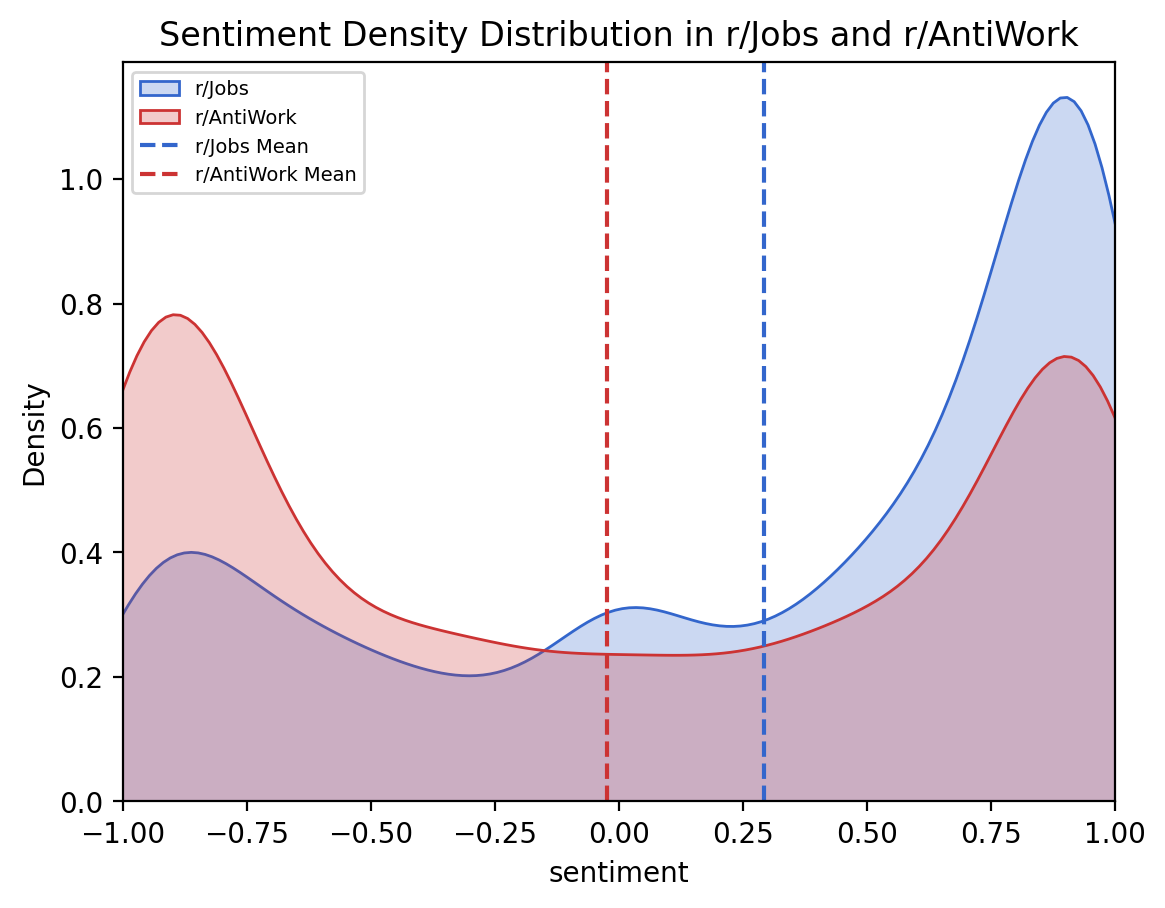

In [133]:
plt.figure(dpi=200)
sns.kdeplot(jobs['sentiment'], fill=True, label='r/Jobs', color=jobs_color)
sns.kdeplot(anti['sentiment'], fill=True, label='r/AntiWork', color=anti_color)
plt.axvline(x=sub_sentiment.values[1], color=jobs_color, linestyle='--', label='r/Jobs Mean')
plt.axvline(x=sub_sentiment.values[0], color=anti_color, linestyle='--', label='r/AntiWork Mean')
plt.legend(loc=2, fontsize=7)
plt.xlim(-1, 1)
plt.title('Sentiment Density Distribution in r/Jobs and r/AntiWork');

There is an overall tendency towards polarization, even leaving aside the question of subreddits. The bump in the middle is somewhat artificial because the sentiment analyzer defaults to 0 in some cases where it can't determine a sentiment (urls, etc.)

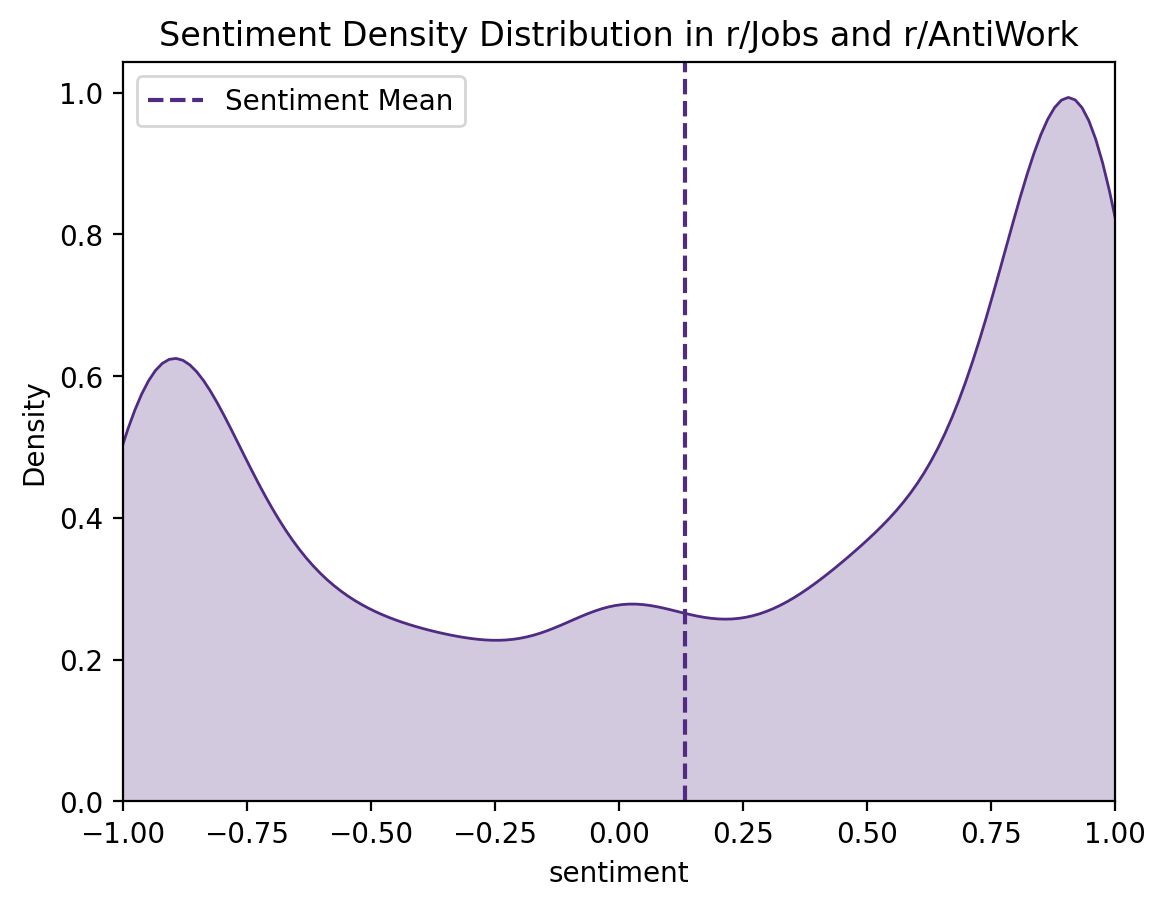

In [134]:
plt.figure(dpi=200)
kde_color = '#502b83'
sns.kdeplot(df['sentiment'], fill = True, color = kde_color)
plt.axvline(x = sub_sentiment.values.mean(), linestyle='--', label='Sentiment Mean',\
            color = kde_color)
plt.legend(loc=2, fontsize=10)
plt.xlim(-1, 1)
plt.title('Sentiment Density Distribution in r/Jobs and r/AntiWork');

There's a bump towards the middle of the data which is caused by the sentiment analyzer setting some posts to 0.0, which is partially because some of the posts are simply URLs, etc.:

In [135]:
df[df['sentiment'] == 0]['selftext'][284]

'https://en.wikipedia.org/wiki/Frank_Little_(unionist)'

In [136]:
len(df[df['sentiment'] == 0])*100 / len(df)

3.0699839953441

Currently, 4% of all posts have 0.0 as the sentiment score.

In [137]:
df[df['sentiment'] == 0]['selftext']

56      This is what the PH lawyer brought as a gestur...
97      So was grabbing a late lunch with my husband a...
220     Says they are only looking to hire 1 more pers...
284     https://en.wikipedia.org/wiki/Frank_Little_(un...
310     Average monthly net salary: 1. Switzerland 🇨🇭:...
                              ...                        
6742    I’ve been applying for jobs last 9 months and ...
6788    I get the purpose of the question is how one d...
6791    \nI work for a large company and am a salary e...
6800    An overview of my 4 months period of non-stop ...
6805    Anyone else? \n\nI’ve applied through LinkedIn...
Name: selftext, Length: 211, dtype: object

In [138]:
df[df['sentiment'] == 0]['selftext'][220]

'Says they are only looking to hire 1 more person. Went from being 2 people on shift to now only ever 1 on shift with all of us working over our contracted hours. A nightmare place to work.'

I picked this post out without seeing past the first sentence. I don't think that "A nightmare place to work." is a neutral sentiment. Instead, it's simply too short for the sentiment analyzer to be able to make a prediction.

In [139]:
df[df['sentiment'] == 0]['selftext'][56]

'This is what the PH lawyer brought as a gesture of goodwill to the meeting with the tech union. A box of already-eaten donuts.'

Again, another post which is too short for the sentiment analyzer, and it's probably an image post as well. This is clearly not a neutral sentiment. I think I'll try removing all URLs from the corpus, and then set a minimum post length. Then I'll see if that removes some of the sentiment = 0.0 instances.

*WORDCOUNT FUNCTION*:

In [350]:
def wordcount(corpus):
    wordcount  = []
    for c in corpus:
        wordcount.append(len(c.split(' ')))
    return wordcount

df['wordcount'] = wordcount(df['selftext'])

In [141]:
df['selftext'][0]

'I wanted to get some opinions regarding something my wife recently went through. As the title reads, my wife was invited to a “working Interview” with a large animal veterinarian clinic. After a 9 hour day, she had administered 5 vaccines to 5 different animals, held down 3 Full-size Rams, and was in 90 degree weather for almost the entirety of the day. After her day of working, she was told they liked her and they would be in touch the following Monday. She was completely ghosted and was not compensated at all for the day. They have failed to respond to our inquiries even 2 weeks after this event. Thankfully my wife is now employed. It made me wonder if a company could legally get away with “working interviews” in large amounts to effectively get free labor.'

In [142]:
df['wordcount'][0]

138

The wordcount function I made and wordcount.com are in agreement that this string contains 138 words, so it should be working as expected.

*REMOVING URLS*:

https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python

In [143]:
test_text = list(df[df['sentiment'] == 0]['selftext'])[60:][9]
test_text

'https://t.mmears.com?referralCode=T4678500 It is an online company that is looking for tutors that can teach in English.'

This will be a good test post since it contains both a url and regular text.

In [144]:
df['selftext'][:5]

0    I wanted to get some opinions regarding someth...
1    Basically title. I’ve gotten several good job ...
2    I really want to share my experience that comp...
3    My company leadership said they wanted to buy ...
4    Just got my first paycheck at my new job and I...
Name: selftext, dtype: object

In [145]:
re.sub(r'http\S+', '', test_text)

' It is an online company that is looking for tutors that can teach in English.'

It left the newline character behind, but that's actually a sign that the regex is doing what it's supposed to.

In [146]:
len(df['selftext'])

6873

In [147]:
df['selftext'] = [re.sub(r'http\S+', '', s) for s in df['selftext']]
empty_index = [i for i in range(len(df['selftext'])) if df['selftext'][i] == '']
df.drop(index = empty_index, inplace = True)
df['selftext'].shape

(6863,)

Eight posts containing nothing but URLs were dropped

In [216]:
#df[df['sentiment'] == 0]['selftext'][286]

The post which contained only this URL `https://en.wikipedia.org/wiki/Frank_Little_(unionist)` is now gone. Only eight posts were removed, so this probably won't make a huge effect, but I can now filter out posts which are too short.

*FILTERING POSTS BY LENGTH*:

In [149]:
df[df['sentiment'] == 0]['wordcount'].mean().round()

34.0

The average 0 sentiment post has 29 words

In [150]:
df['wordcount'].mean().round()

211.0

Compared with 198 for the average post. Clearly, these posts are vastly shorter than average.

In [151]:
df['wordcount'].describe()

count    6863.000000
mean      210.534169
std       200.587494
min         1.000000
25%        82.000000
50%       155.000000
75%       267.000000
max      2394.000000
Name: wordcount, dtype: float64

Solely for the sake of creating a more accurate visualization by removing the artificial bump towards sentiment  = 0, which is caused by the sentiment analyzer not being able to understand short posts, I'll create a new dataframe with only posts above 76 words in length words in length, which is the 25th percentile. This should be a fairly conservative approach to getting a more realistic output as far as the sentiment graphs are concerned. I won't use this dataframe for modeling, only for eda.

In [152]:
df_verbose = df[df['wordcount'] > 76]

In [316]:
sub_sentiment.values.mean().round(2)

0.13

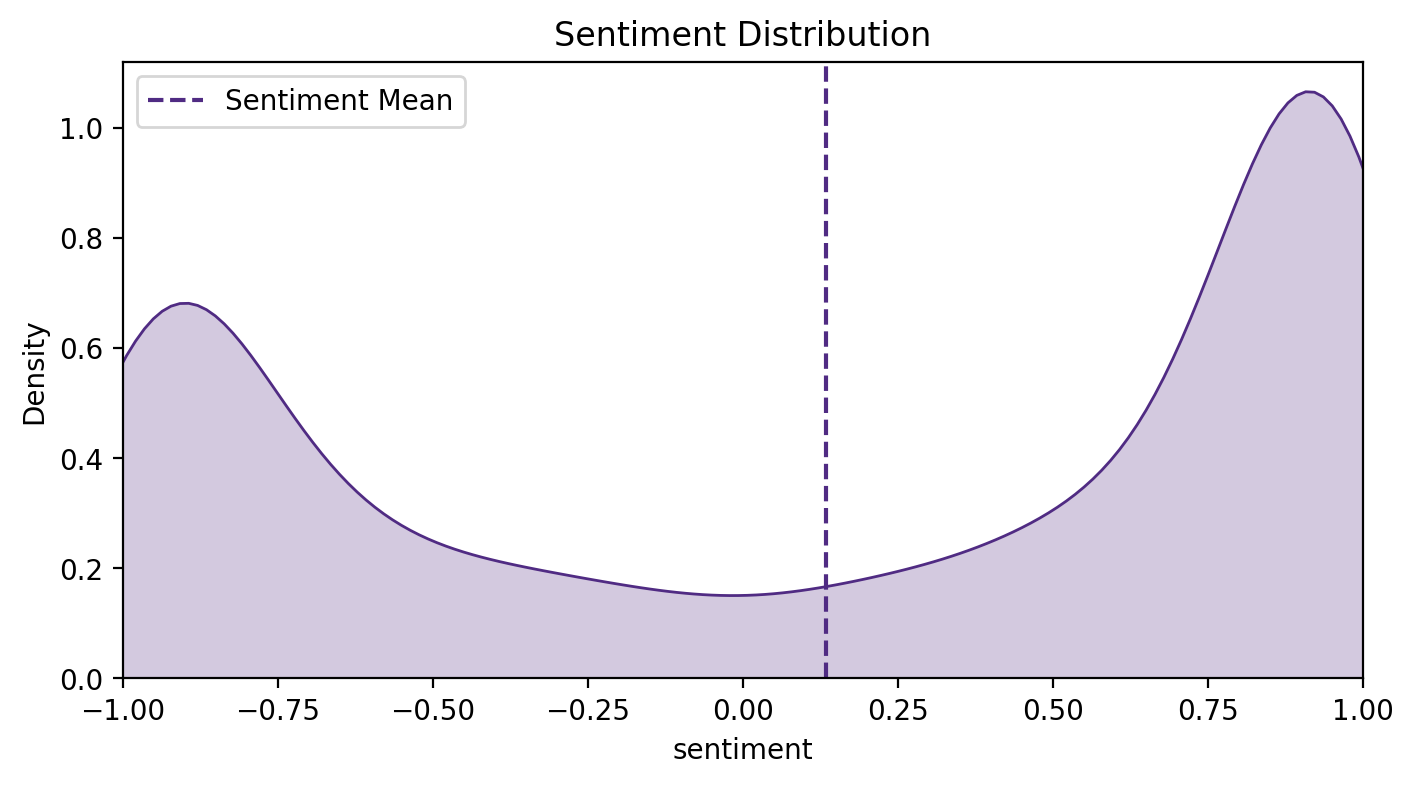

In [324]:
plt.figure(dpi=200, figsize = (8, 4))
kde_color = '#502b83'
sns.kdeplot(df_verbose['sentiment'], fill = True, color = kde_color)
plt.axvline(x = sub_sentiment.values.mean(), linestyle='--', label='Sentiment Mean',\
            color = kde_color)
plt.legend(loc=2, fontsize=10)
plt.xlim(-1, 1)
plt.title('Sentiment Distribution');
plt.savefig('sentiment_distribution.png');

This graph seems more realistic to me. There is a very clear poliarization here, where the majority of posts are either considered strongly positive or strongly negative. Sentiment = 0 is in reality one of the most infrequent areas, i.e. almost no posts have a non-polarized sentiment. That said, more posts are positive sentiment than negative.

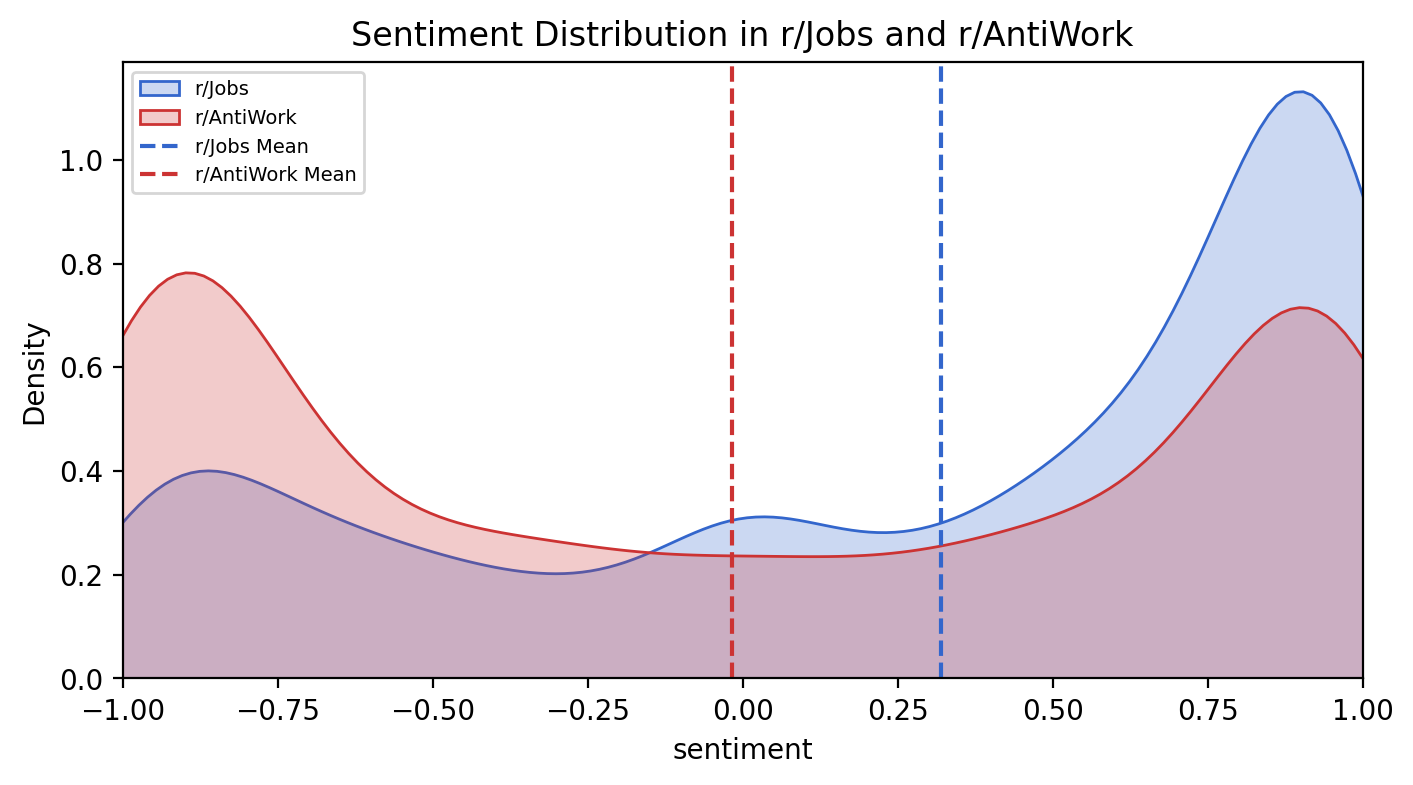

In [326]:
anti_verbose = df_verbose[df_verbose['subreddit'] == 'antiwork']
jobs_verbose = df_verbose[df_verbose['subreddit'] == 'jobs']

plt.figure(dpi=200, figsize = (8, 4))
sns.kdeplot(jobs['sentiment'], fill=True, label='r/Jobs', color=jobs_color)
sns.kdeplot(anti['sentiment'], fill=True, label='r/AntiWork', color=anti_color)

verbose_sentiment = df_verbose.groupby('subreddit').mean(numeric_only = True)['sentiment']
verbose_sentiment

plt.axvline(x=verbose_sentiment.values[1], color=jobs_color, linestyle='--', label='r/Jobs Mean')
plt.axvline(x=verbose_sentiment.values[0], color=anti_color, linestyle='--', label='r/AntiWork Mean')
plt.legend(loc=2, fontsize=7)
plt.xlim(-1, 1)
plt.title('Sentiment Distribution in r/Jobs and r/AntiWork');
plt.savefig('sentiment_distribution_subs.png')

r/Jobs still reveals a bump towards sentiment = 0, although I don't think this is implausible

In [328]:
verbose_sentiment.round(2)

subreddit
antiwork   -0.02
jobs        0.32
Name: sentiment, dtype: float64

In [155]:
jobs[(jobs['sentiment'] > -.5 ) | (jobs['sentiment'] < .5)]['selftext'][703]

'(Not sure if this type of question is allowed here, so I thought I’d shoot my shot and if it gets removed then I learn) Just bought this shirt and absolutely love it, but I’m not sure if it’s work appropriate so I dunno if I should be wearing it to work at all. Too scared to try wearing it in case management gets mad so I wanted to get a second opinion. I work at h&m, as a sales coach. I’m more worried about the Jesus figure, as they sell Keith haring stuff there already. Thanks!'

I removed newline characters from the selftext during the cleaning phase, but they appear to have worked their way back in.

I'm curious to see the sentiment distribution across the subreddits for posts mentioning the word "manager" and "interview"

In [199]:
manager_index = [s for s in range(len(df_verbose['selftext'])) if 'manager' in df['selftext'][s].lower()]
manager_df = df_verbose.iloc[manager_index]

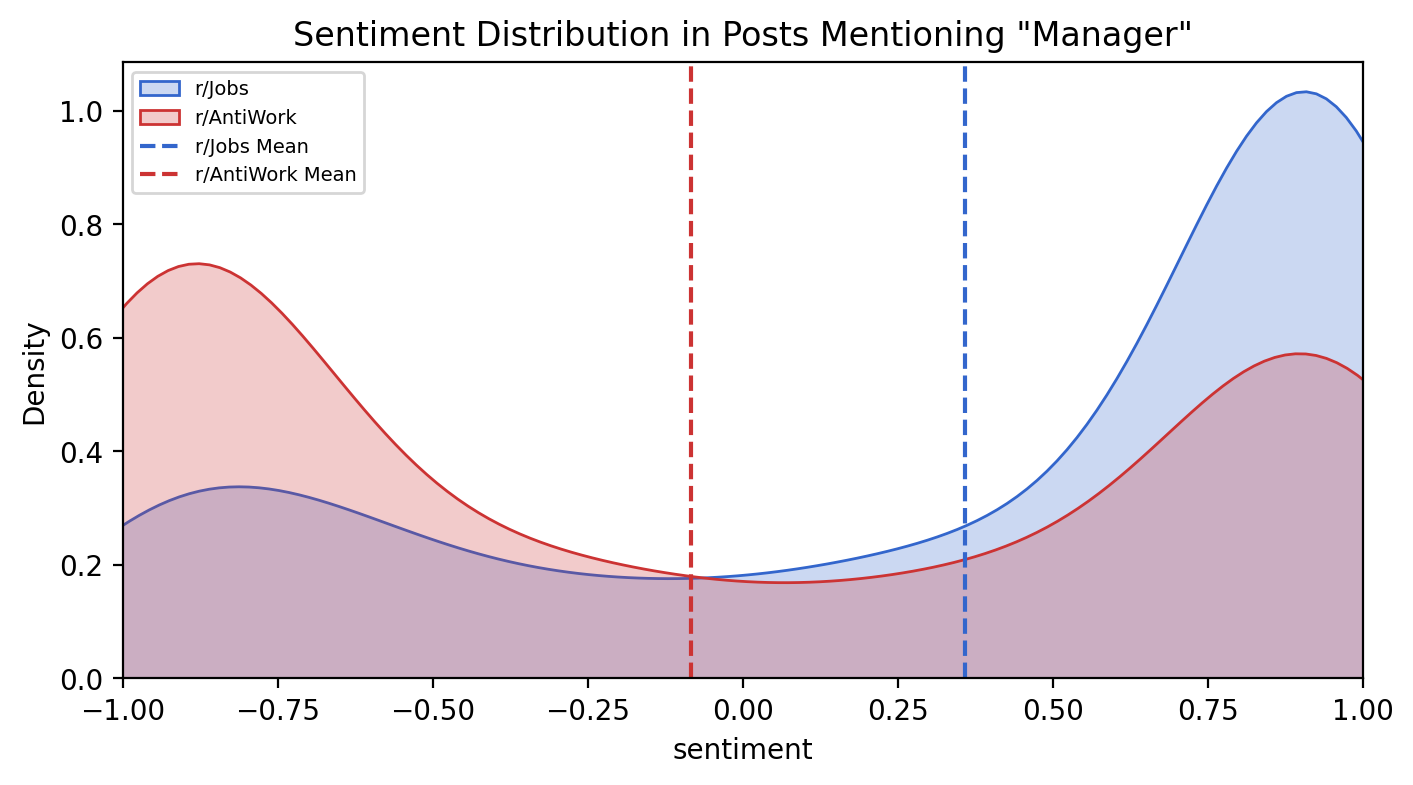

In [343]:
anti_manager = manager_df[manager_df['subreddit'] == 'antiwork']
jobs_manager = manager_df[manager_df['subreddit'] == 'jobs']

# creating mean sentiment scores for the dotted line
manager_sentiment = manager_df.groupby('subreddit').mean(numeric_only = True)['sentiment']
manager_sentiment

plt.figure(dpi=200, figsize = (8, 4))
sns.kdeplot(jobs_manager['sentiment'], fill=True, label='r/Jobs', color=jobs_color)
sns.kdeplot(anti_manager['sentiment'], fill=True, label='r/AntiWork', color=anti_color)
plt.axvline(x=manager_sentiment.values[1], color=jobs_color, linestyle='--', label='r/Jobs Mean')
plt.axvline(x=manager_sentiment.values[0], color=anti_color, linestyle='--', label='r/AntiWork Mean')
plt.legend(loc=2, fontsize=7)
plt.xlim(-1, 1)
plt.title('Sentiment Distribution in Posts Mentioning "Manager"');
plt.savefig('manager_sentiment_distribution.png')

I'm also curious about posts mentioning the word "interview". I expected "manager" to be the most quintisental r/AntiWork phrase, and I expect "interview" to be the most quintisential r/Jobs phrase.

In [345]:
manager_sentiment.round(2)

subreddit
antiwork   -0.08
jobs        0.36
Name: sentiment, dtype: float64

In [200]:
interview_index = [s for s in range(len(df_verbose['selftext'])) if 'interview' in df['selftext'][s].lower()]
interview_df = df_verbose.iloc[interview_index]

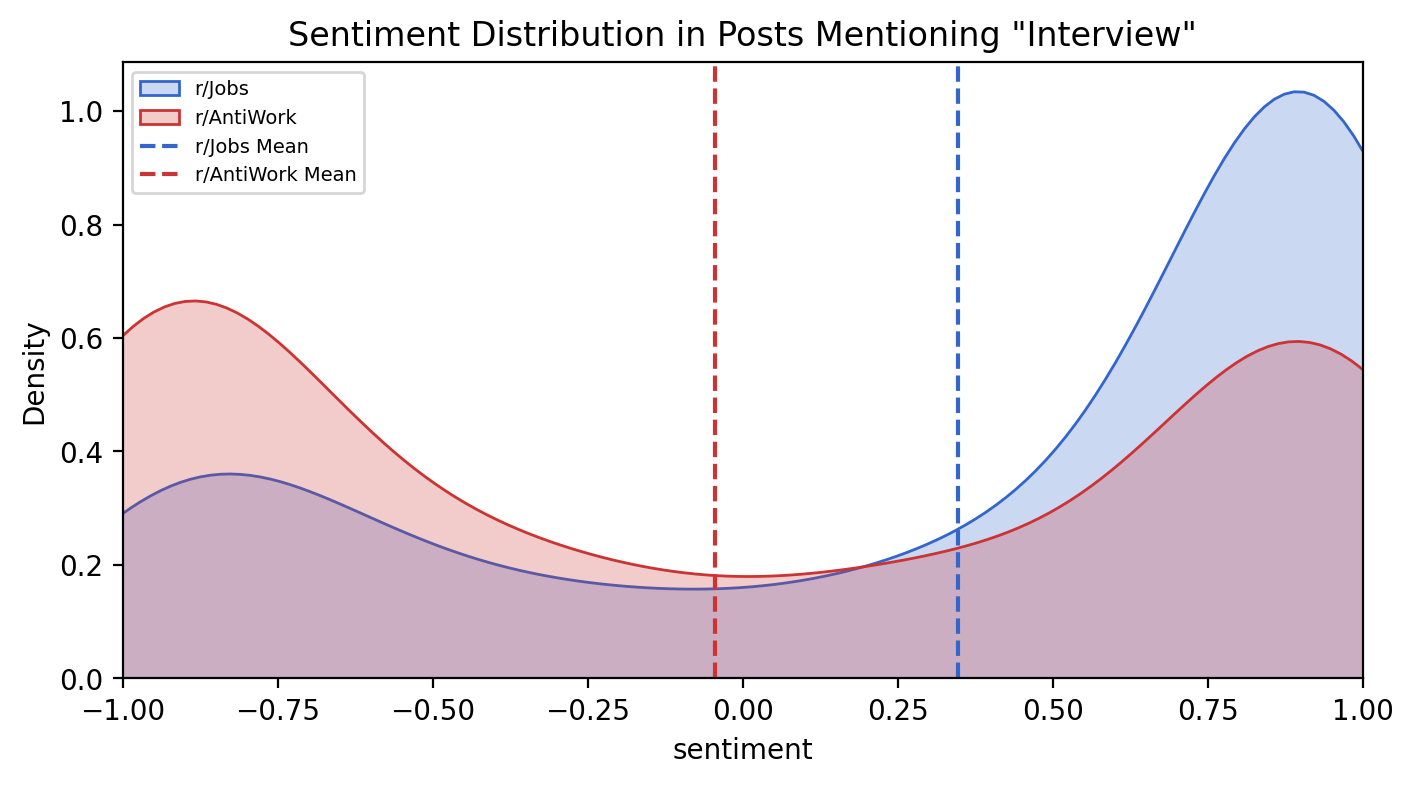

In [346]:
anti_interview = interview_df[interview_df['subreddit'] == 'antiwork']
jobs_interview = interview_df[interview_df['subreddit'] == 'jobs']

# creating mean sentiment scores for the dotted line
interview_sentiment = interview_df.groupby('subreddit').mean(numeric_only = True)['sentiment']
interview_sentiment

plt.figure(dpi=200, figsize = (8, 4))
sns.kdeplot(jobs_interview['sentiment'], fill=True, label='r/Jobs', color=jobs_color)
sns.kdeplot(anti_interview['sentiment'], fill=True, label='r/AntiWork', color=anti_color)
plt.axvline(x=interview_sentiment.values[1], color=jobs_color, linestyle='--', label='r/Jobs Mean')
plt.axvline(x=interview_sentiment.values[0], color=anti_color, linestyle='--', label='r/AntiWork Mean')
plt.legend(loc=2, fontsize=7)
plt.xlim(-1, 1)
plt.title('Sentiment Distribution in Posts Mentioning "Interview"');
plt.savefig('interview_sentiment_distribution_subs.png')

Neither of these keywords really have that much of an effect. The sentiment is already so highly polarized that the difference is very minor. A huge number of posts mentioning an interview in r/Jobs have very positive sentiment, and the same is true for "manager". Interestingly, the sentiment for "manager" is actually slightly stronger than "interview" in r/Jobs.

In [347]:
interview_sentiment.round(2)

subreddit
antiwork   -0.04
jobs        0.35
Name: sentiment, dtype: float64

## Wordcount

Plotting distribution of wordcount using the original dataframe:

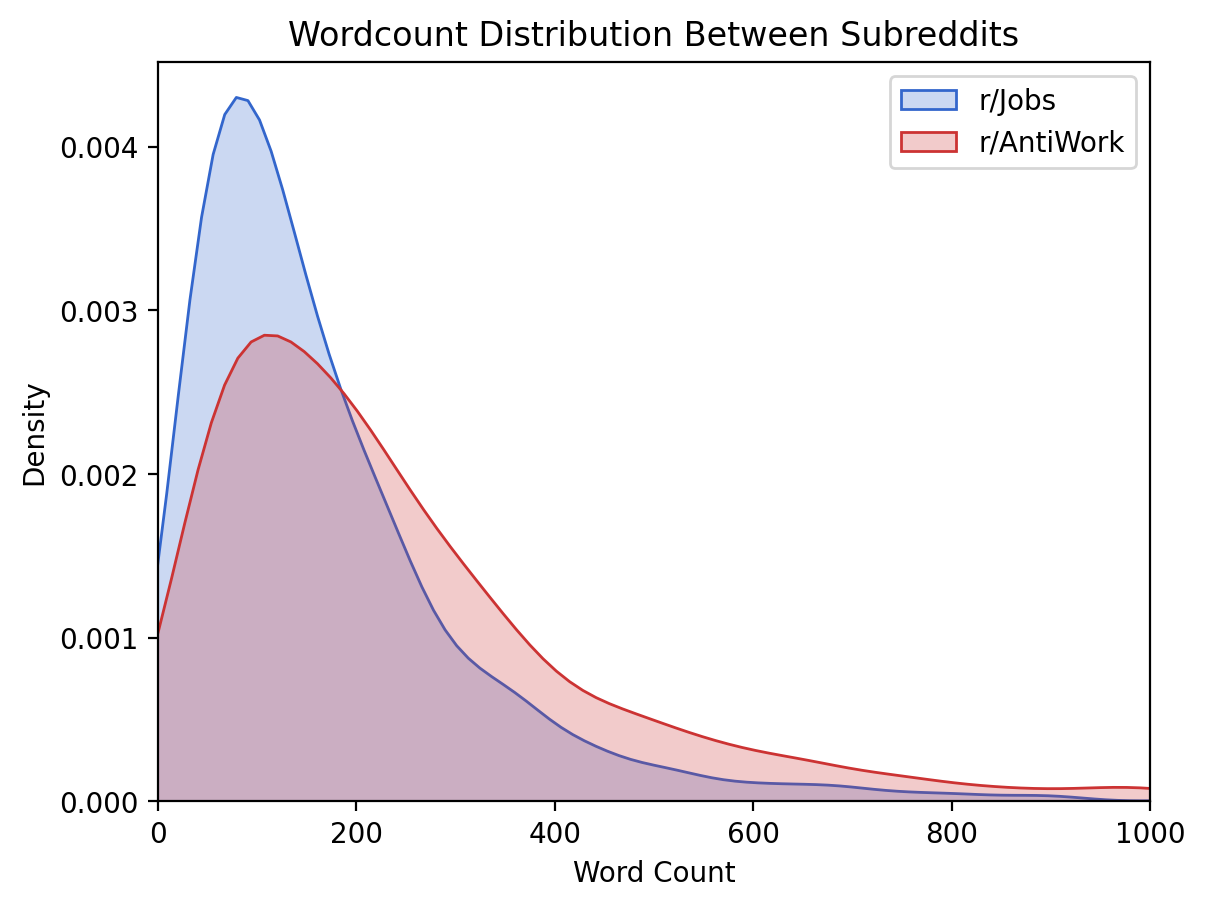

In [357]:
plt.figure(dpi = 200)
sns.kdeplot(df[df['subreddit'] == 'jobs']['wordcount'], fill = True, color = jobs_color, label = 'r/Jobs');
sns.kdeplot(df[df['subreddit'] == 'antiwork']['wordcount'], fill = True, color = anti_color, label = 'r/AntiWork');
# plt.axvline(x = df[df['subreddit'] == 'jobs']['wordcount'].mean(), color=jobs_color, linestyle='--', label='r/Jobs Mean')
# plt.axvline(x = df[df['subreddit'] == 'antiwork']['wordcount'].mean(), color=anti_color, linestyle='--', label='r/AntiWork Mean')
plt.xlim(0,1000)
plt.legend();
plt.title('Wordcount Distribution Between Subreddits');
plt.xlabel('Word Count');
plt.savefig('wordcount_distribution.png');

This plot shows that posts on r/AntiWork are longer on average than those on r/Jobs, which runs contrary to my assumption going into this project that this subreddit was more meme-oriented. In order for this to be a good plot for a PowerPoint, it will need some explaination, and it's certainly not one for a non-technical audiance. It's also not the best for displaying mean wordcount, as that's a secondary feature being displayed. On second thought, I'll remove the mean lines entirely, since I already have a barplot displaying this.

As far as understanding distribution goes though, I think it's an interesting plot. It shows that for both subreddits, the vast majority of posts are relatively short (around 200 words), but there are a small minority of users who create extremely long posts, with some on r/AntiWork spanning well beyond 1,000 words. The max wordcount I saw on r/AntiWork was 2,400 words:

In [158]:
df[df['subreddit'] == 'antiwork']['wordcount'].max()

2394

r/Jobs also has a small number of very long posts, but in general, the users on that subreddit seem less inclined to create essay-length posts.

As far as displaying the mean wordcount though, a simple bar plot will be much nicer:

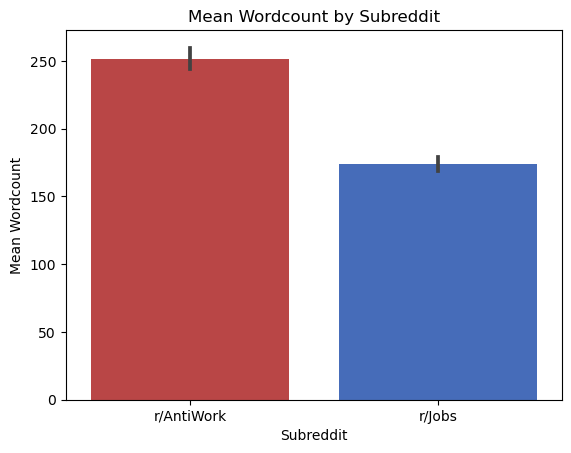

In [159]:

sns.barplot(data = df[['wordcount', 'subreddit']], x = 'subreddit', y = 'wordcount', palette = [anti_color, jobs_color]);
plt.title('Mean Wordcount by Subreddit');
plt.xlabel('Subreddit');
plt.ylabel('Mean Wordcount')
plt.xticks([0,1], ['r/AntiWork', 'r/Jobs']);
plt.savefig('wordcount_barplot.png');

*Finding example posts for the PowerPoint:*

I'll now find a couple of example posts which are atypical for the subreddit they come from in order to do the corny thing that people giving presentations do where they attempt to surprise their audiance by giving an example which defies expectations.

In [211]:
# r/Jobs example
print(df['selftext'][5000])
print(df['subreddit'][5000])

3 years ago I started a new job in a new city. It was the worst mistake of my life. The people are truly horrific. Everything is an argument, debate, and back and forth. I am completely convinced several of my coworkers suffer from anti-social personality disorders as they will literally make up reasons to engage in conflict. HR and management are aware, but said coworkers are in a powerfull union, and despite each of them having HR files like dictionaries, nothing can be done. I should have left when the job market wasn't so fucked, but now its been months of trying and escape seems impossible when every job gets 500 applicants. Yesterday I walked out and will be home "sick" for the next 3 days as I was likely going to literally physically hurt someone if I didn't. I am a full time employee at a large corporation in Philadelphia, Pennsylvania. I am also in a union. I know FMLA is a thing but I dont know how to navigate it. How do I get time off to just stay home and decompress before 

In [365]:
# r/AntiWork example
df[(df['sentiment'] > .8) & (df['subreddit'] == 'antiwork')][700:705]

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,crosspost_parent,post_hint,preview,author_cakeday,is_gallery,media_metadata,gallery_data,link_flair_template_id,sentiment,wordcount
5796,NaN,antiwork,I am an engineer in the construction industry....,t2_4hf4i3xq,False,NaN,0,False,Conversation with mentor from my first job out...,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9874,368
5799,NaN,antiwork,Just a PSA for those doing any knowledge job: ...,t2_6k26zwf3,False,NaN,0,False,AI and Your Job,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9923,405
5802,NaN,antiwork,Saying this from the perspective of a manager ...,t2_pv1rzlws,False,NaN,0,False,Two Types of Management,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9876,348
5803,NaN,antiwork,I (23F) work in a restaurant that requires ser...,t2_kgrjhlkk,False,NaN,0,False,"reported my job for wage theft, investigation ...",[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8228,476
5805,NaN,antiwork,Long story short I'm struggling with some pers...,t2_5jsik0sv,False,NaN,0,False,Burnout,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8128,142


In [263]:
# r/AntiWork example
df.iloc[6224]['selftext']

'Pretty close to a dream job. Interview went great. Told I was the perfect candidate. Introduced to everyone, including the top-brass bosses. Immediately asked for references, which, to me, means I have the job after the formalities. \n\nLike two weeks later, nothing. In the meantime, I have other job offers. But not nearly as "big-time and $20-$40K lower salary. But they\'re sure things. \n\nI call the good job and the hiring manager is like, "Yeah, you\'re our top candidate. We just have some things to figure out. We\'ll let you know." \n\nIt\'s just bizarre to me, and I don\'t know what to do. Pretty scared I\'ll keep holding out for the best job and end up totally empty-handed and have to start all over from square one. \n\nSo frustrating. ... Also, next person I hear say, "NoBoDy WaNtS tO wOrK tHeSe DaYs" is getting a fart muffin to the kisser. \n\nEmployers just don\'t want to hire people until they, "figure things out" WTF ever that means. '

I already did data cleaning in the previous notebook, but I'll have to do this again manually.

In [278]:
anti_example = df.iloc[6224]['selftext'].replace("\n", '')
anti_example = anti_example.replace(r"\"", "")

In [276]:
# the backslashes are still present
anti_example

'Pretty close to a dream job. Interview went great. Told I was the perfect candidate. Introduced to everyone, including the top-brass bosses. Immediately asked for references, which, to me, means I have the job after the formalities. Like two weeks later, nothing. In the meantime, I have other job offers. But not nearly as "big-time and $20-$40K lower salary. But they\'re sure things. I call the good job and the hiring manager is like, "Yeah, you\'re our top candidate. We just have some things to figure out. We\'ll let you know." It\'s just bizarre to me, and I don\'t know what to do. Pretty scared I\'ll keep holding out for the best job and end up totally empty-handed and have to start all over from square one. So frustrating. ... Also, next person I hear say, "NoBoDy WaNtS tO wOrK tHeSe DaYs" is getting a fart muffin to the kisser. Employers just don\'t want to hire people until they, "figure things out" WTF ever that means. '